In [ ]:
! pip install langchain_core langchain_community langchain_openai langgraph cachetools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found exi

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Optional, Literal, Annotated, TypedDict
from langchain_community.chat_message_histories import ChatMessageHistory
from cachetools import TTLCache
from datetime import date
import re
import uuid
import time
from langgraph.graph import StateGraph,END,START
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from IPython.display import Image, display

In [ ]:
from langchain_openai import ChatOpenAI  # NEW import

llm_router = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    max_tokens=50,
    model_kwargs={
        "presence_penalty": 1.0,
        "frequency_penalty": 1.0
    }
)

llm_node = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    max_tokens=100,
    model_kwargs={
        "presence_penalty": 1.0,
        "frequency_penalty": 1.0
    }
)


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: UserWarning: Parameters {'frequency_penalty', 'presence_penalty'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: UserWarning: Parameters {'frequency_penalty', 'presence_penalty'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
route_prompt="""you are an expert classification agent and you can speak hindi and english. classify the request as per the conversation provided to you.
The conversation contains the assistant response and human response. your task is to analyze the Human Response.
If the user response for the questions like salaried, self-employed , nature of bussiness, rental, own ,designation if they ask any question respond with we only provide to salaried people and to provided the best suitable loan sceme.
If the user say okay and then respond with 'main_node'.
whenever the user ask like emi eralted query and wantt to talk to agent like connect me to the agent then always goes to main_node.
-If the Human Response is not related to the pre-approved personal loan or topic being discussed respond with 'irrelevent'.
-If the Human Response say he/she is busy  or requesting to talk after sometime respond 'busy'.
-If the Human Response say wrong number respond 'wrong_number.
-If the Human Response indicates interest in taking loan ,requesting details, agree to continue the conversation or share personal information respond with 'agent'.
-If the Human Response contains any refusal like no to accept the loan respond with 'reject'.
-If the Human Response say to repeat what said before or say again or similar word then respond with 'repeat'.
-If the user wants to respons be in some specific langugae add that language to 'language' respond with 'res_language'.
-If the user say 'I dont  have any questions' then only respond 'agent_node'.

Give the Human Response , your task  is to predict the original language of the text  and then store it in 'languae' field the human response can be in that specific language.
"""



In [ ]:
route_prompt_temp = ChatPromptTemplate.from_messages(
    messages=[
        ("system", route_prompt),
        ("placeholder", "{chat_history}"),
        ("user", "{user_input}")
    ]
)

In [ ]:
class Route(BaseModel):
    step: Literal["busy","wrong_number","info_wrong","irrelevant_ans","reject","repeat","res_language","agent_node"] = Field(None,
        description="Classify the use message into these catogries."
    )
    language: Literal["English","Hindi"]= Field(None,description="Classify the user message based on the spoken language and respond properly in that particular language.")

router = llm_router.with_structured_output(Route)

chain = route_prompt_temp | router

In [ ]:
class NodeResponse(BaseModel):
    response: str = Field(None,description="Response of for the user message.")
    status: Literal["end","continue"] = Field(None,description="Status of the conversation to end conversation or continue.")

node_message = llm_node.with_structured_output(NodeResponse)

examples_hindi = """Use this examples while responding in Hindi:
    for "shortlisted" use "शॉर्टलिस्टेड"
    for "quick" use "क्विक"
    for "interest rate" use "इंटरेस्ट रेट"
    for "quick dispersal" use "क्विक डिस्पर्सल" यदि मुझे जल्द से जल्द लोन चाहिए तो कितना लगेगा
    for "self employed" use "सेल्फ एम्प्लॉयड"
    for "interested" use "इंटरेस्टेड"
    for "This is a limited period offer on your pre approved personal loan" use एक सीमित पीरियड ऑफर है आपके प्री अप्रूव पर्सनल लोन पर
    for "Pre Approved Personal Loan" use ये असुरक्षित व्यक्तिगत ऋण
    for "personal" use "पर्सनल"
    for "pre approved" use "प्री अप्रूव्ड"
    for "competitive" use "कम्पेटिटिव"
    for "tenure" use "टेनुरे"
    for "Salaried" use "सैलरीड"
    for "designation" use "डेसिग्नेशन"
    for "salaried" use "सैलरीड"
    for "designation" use "डेसिग्नेशन"
    for "eligible" use "एलिजिबल"
    for "recommend" use "रिकमंड"
    for "connect" use "कनेक्ट"
    for "loan" use "लोन"
    for "business" use "बिजनेस"
    for "nature" use "नेचर"
For while I am connecting you to the agent,Could you please let me know if you are salaried or self-employed" use जब तक में आपको एजेंट से कनेक्ट कर रही हू क्या आप मुझे बताएंगे की आप सैलरीड है या सेल्फ एम्प्लॉयड?"
"""
words=["50 words","30 words"]

In [ ]:

prompt_gpt_reason="""You are a virtual assistant for the MinMac Capital Team whose in a conversation with a Human who can be male or female and don't assume it to be specific gender.
(examples_hindi)

Scenarios:

For the first response, the user says yes or sure or okay or speak or tell like, Thats great!,You are eligible for a loan of (Amount) at an interest rate (ROI)% with duration of {duration} months.
If the user is interested in taking the loan (for example, by saying 'I want to apply for the loan' or 'What are the next steps to get the loan') or ask more information.

For Salaried
-Ask questions, Could you kindly tell us regrading your designation? in {language).set the status as continue.
-User response can be anything.Designation may be anything, Like farmerre, lawyer, It employee etc.
-Ask question,Based on your aadhar card address, are you staying in own or rental house?in {language).set the status as continue.
-Ask question, Could you please let me know a convenient time for our agent to call you back in (language).set the status as end.
-Respond Thank you,our agent will call you back at preferred time,.Have a great day in (language).set the status as end.

For Salaried
-Ask questions, Could you kindly tell us regrading your designation? in {language).set the status as continue.
-User response can be anything.Designation may be anything, Like farmerre, lawyer, It employee etc.
-Ask question,Based on your aadhar card address, are you staying in own or rental house?in {language).set the status as continue.
-Ask question, Could you please let me know a convenient time for our agent to call you back in (language).set the status as end.
-Respond Thank you,our agent will call you back at preferred time,.Have a great day in (language).set the status as end.

If the user ask questions about the interest rate:
-Asks about interest rate/your interest rate is (ROI)% for this PAPL Please ask if you have more questions?I can help you in answering them Rephrase it.
-Interest rate is too high/Competitive Interest Rates: We offer the lowest interest rates, especially when compared to NBFC Rephrase it.
-Interest range:(The interest rate ranges from 11.99% to 29.99%,please ask if you have more questions?I can help you in answering them" Rephrase it and respond in {language}.


If the user asks about the E M I details or anything about E. M. I.:
-Respond for the more detail s regarding the E.M.I. , our agent can help you with this details, do you have any other queries further related to loan in {language}.

Response must be consistant with user {language}.
users with personal loan inquiries, approvals, fees, and eligibility. Always respond in the user’s chosen {language} and end each message with Status: continue.

If the user asks multiple questions, respond with: "Sure—what queries do you have? I’m here to help.
For hidden charges, respond: "There are no hidden charges for the pre-approved personal loan.
If the user agrees to proceed, respond: "You are eligible for a loan based on the details provided." Include relevant next steps.
If asked about documents, reply: "We offer quick disbursal with no documents required. An agent will reach out to assist you.
If the user requests a higher loan amount or lower interest rate, say: "Let me check the available options for higher amount or reduced rate.
For the query: "What amount will I get in my bank at 11.7% interest?", respond: "With this offer, your bank disbursal amount will be shared shortly. Tata Capital charges Rs 358 + GST per month, and processing fees up to 4% of the loan amount + GST.
If asked about processing fees, reply: "A one-time processing fee up to 4% of the loan amount plus GST applies. The loan is unsecured, so no collateral is needed.
If asked about collateral, respond: "No collateral or security is required for this personal loan.
If the user inquires about part-payment or foreclosure charges, reply: "A part-prepayment or foreclosure charge of 4.5% applies on the principal outstanding at the time of repayment.
If asked about discounts or promotional offers, say: "Interest rates and offers may vary. I can help check any ongoing promotions.
If asked whether better credit scores offer lower rates, reply: "Yes, factors like CIBIL score, income, and employment history influence interest rates.
For any question on what influences personal loan rates, respond: "Yes, your CIBIL score, income, tenure, and loan amount all affect the offered interest rate.
If asked about additional personal loan costs, reply: "There is a one-time processing fee of up to 4% of the loan amount plus GST.
For any unclear input, ask: "I’m not sure I understand—could you please elaborate?


Response Guidelines:
When crafting your response, imagine you're having a casual conversation with a close friend. Use everyday language and make it relatable and easy to understand.
Be polite, empathetic, and persuasive.
Give the response in female tone and in (language).
The bot response should be almost (words).
At every end of the response questions ask "please ask if you have more questions I can help you in answering them in {language}" Rephrase it.
Instead of EMI, you can use E M I."""

In [ ]:
prompt_gpt_busy="""you are an assistant for the MixMac Team who is in conversation with huamn who can be female or male and Avoid making assumptions about the user's gender and respond accordingly.
If the busy_counter is more than 2, Say Thank you for the time, Respond in female tone in {language}.Set status to end.
If the customer says Busy:
-Politely tell "This is a limited period offer regarding your pre-approved personal loan. Do you want to avail of this offer?" Rephrase it. Respond in female tone in {language}.
-Politely ask "can you please suggest a suitable time to call?" Rephrase it.Respond in female tone in {language}.Set status to continue.
-Politely thank them and tell them you'll call at the preferred time. Have a great day in {language}.Set status to end.
-The bot response should be almost (words).
"""

In [ ]:

agent_gpt_reason_prompt="""you are an assistant for the MixMac Team who is in conversation with huamn who can be female or male and Avoid making assumptions about the user's gender and respond accordingly.
{examples_hindi}

Follows this order:
If user says No,I don't have any questions?: rephrase it in {language}.set the status as continue.
-Ask would you like to connect with an agent? rephrase it in {language}.

Response Guidelines:
When crafting your response, imagine you're having a casual conversation with a close friend. Use everyday language and make it relatable and easy to un
Be polite, empathetic, and persuasive.
Give the response in female tone and in {language}.
The bot response should be almost (words).
"""

In [ ]:
from typing import Optional
from typing import Annotated, Literal, Sequence, TypedDict
import operator
from langgraph.graph import END, StateGraph, add_messages
from langchain_core.messages import BaseMessage

class State(BaseModel):
    messages: Annotated[Sequence[BaseMessage], Field(..., description="Add messages")]
    context: dict
    number_conversation: Annotated[int, Field(default=1, description="Number of conversations")]
    today_date: str
    user_text: str
    decision: str
    output: str
    status: str
    language: str
    busy_counter: Annotated[int, Field(default=0)]
    refusal_counter: Annotated[int, Field(default=0)]

In [ ]:
template = ChatPromptTemplate([
    ("system", "{prompt_gpt_reason}"),
    # Means the template will receive an optional list of messages under
    # the "conversation" key
    ("placeholder", "{chat_history}")
    # Equivalently:
    # MessagesPlaceholder(variable_name="conversation", optional=True)
])


In [ ]:
# main_template = ChatPromptTemplate(
#     messages=[
#         ("system", prompt_gpt_reason),
#         ("placeholder", "{chat_history}"),
#     ],
# )
main_template = ChatPromptTemplate([
    ("system","{prompt_gpt_reason}"),
    ("placeholder", "{chat_history}")
])
main_pipeline = main_template | node_message

# main_template_diff = ChatPromptTemplate(
#     ("system", "{prompt_gpt_reason}"),
#     ("placeholder", "{chat_history}")
# )

# main_pipeline_diff = main_template_diff | node_message
main_template_diff = ChatPromptTemplate([
    ("system", "{prompt_gpt_reason}"),
    ("placeholder", "{chat_history}")
])
main_pipeline_diff = main_template_diff | node_message


In [ ]:
main_template=""
main_pipeline = main_template | node_message

main_template_diff = ChatPromptTemplate.from_messages(
    messages=[
        ("system", prompt_gpt_reason),
        ("placeholder", "{chat_history}")
    ]
)

main_pipeline_diff = main_template_diff | node_message


TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

In [ ]:
def main_node(state: State):
    """Main node handles the RTP and PTP scenarios"""
    result = main_pipeline_diff.invoke({
        "chat_history": state["messages"],
        "language": state["language"],
        "examples_hindi": examples_hindi,
        "ROI": state["context"],
        "prompt_gpt_reason": prompt_gpt_reason  # ✅ Pass it here
    })
    return {
        "messages": [AIMessage(content=result.response), HumanMessage(content=state["user_text"])],
        "output": result.response,
        "status": result.status,
        "language": state["language"],
        "today_date": str(date.today()),
        "context": state["context"]
    }


In [ ]:
agent_template_diff = ChatPromptTemplate.from_messages(
    [
        ("system", agent_gpt_reason_prompt),
        ("placeholder", "{chat_history}"),
        ("user", "{user_text}"),
    ]
)

agent_pipeline_diff = agent_template_diff | node_message


def agent_node(state: State):
    """Main node handles the RTP and PTP scenarios"""
    if state["language"] != "Hindi":
        result = agent_pipeline_diff.invoke({"chat_history": state["messages"], "language": state["language"], "examples_hindi": examples_hindi,"ROI": state["context"]})
        return {
            "messages": [AIMessage(content=result.response), HumanMessage(content=state["user_text"])],
            "output": result.response,
            "status": result.status,
            "language": state["language"],
            "today_date": str(date.today()),
            "context": state["context"],
        }
    else:
        result = agent_pipeline_diff.invoke({"chat_history": state["messages"], "language": state["language"], "examples_hindi": examples_hindi,"ROI": state["context"]})
        return {
            "messages": [AIMessage(content=result.response), HumanMessage(content=state["user_text"])],
            "output": result.response,
            "status": result.status,
            "today_date": str(date.today()),
            "context": state["context"],
        }

In [ ]:
busy_template = ChatPromptTemplate.from_messages(
    [
        ("system", prompt_gpt_busy),
        ("placeholder", "{chat_history}"),
        ("user", "{user_text}"),
    ]
)

busy_pipeline = busy_template | node_message

def busy_node(state: State):
    """Main node handles the RTP and PTP scenarios"""
    result = busy_pipeline.invoke({"chat_history": state["messages"], "language": state["language"], "examples_hindi": examples_hindi,"ROI": state["context"]})
    return {
        "messages": [AIMessage(content=result.response), HumanMessage(content=state["user_text"])],
        "output": result.response,
        "status": result.status,
        "busy_counter": result.busy_counter+1,
    }

In [ ]:
def info_wrong_node(state:State):
    """Apologize for the Inconvenience and tell them will check and come back to you shortly."""
    result = node_message.invoke([SystemMessage(content=f"Apologize for the inconvenience and tell them will check and come back to you shortly.Add the status as end.Give the response in female tone and in {state.language}"), HumanMessage(content=state["user_text"])])
    return {"output":result.response,"status":result.status}


def wrong_number_node(state:State):
    """Apologize for the Inconvenience and wish him a good day."""
    result = node_message.invoke([SystemMessage(content="Apologize for the inconvenience and wish him a good day.Add the status as end.Give the response in female tone and in {language}"), HumanMessage(content=State["user_text"])])
    return {"output": result.response, "status":result.status}


def irrelevant_node(state:State):
    """Politely mention about I am here to discuss your pre approved realted queries and do you have any other querries?I am here to help.Give the response in"""
    result = node_message.invoke([SystemMessage(content="Do not answer the question and tell I am here to discuss your pre approved personal loan related queries and do you save?In {language}"), HumanMessage(content=State["user_text"])])
    return {"output": result.response, "status":result.status}

def repeat_node(state:State):
  result=node_message.invoke(
      [
          SystemMessage(content=f"if the user say repeat, can you repeat the previous response in user lanaguage {state.language}."),
          HumanMessage(content=state["user_text"])
      ]
  )
  return {"output":result.response,"status":result.status}

In [ ]:
reject_prompt = """
You are a virtual assistant for the MinMac Team whose in a conversation with a Human who can be male or female and your responsibility is to persuade
(examples_hindi)

General Persuasion:
-Loan disbursement Confirmation: Upon verification, the amount will be credited to your account within 24 to 48 hours.
-Investment Opportunity: Use the loan amount to fuel the growth of your business.
-Competitive Interest Rates: We offer the lowest interest rates, especially when compared to NBFC.
-Streamlined Process: Bank loan processes are often lengthy and complex, whereas we ensure a simpler experience.
-Repayment Track Record: Loan approval is contingent on your repayment history, ensuring fairness and transparency.
-Limited-Time Offer: This offer may not be available in the future, so we encourage you to act promptly.
-Quick Application: The loan application process is quick and efficient, taking just a few minutes to complete.
-USP Points: Other companies provide minumum 8 days to maximum 18 days to disburse with all documents.
-USP Points: Verification gets delayed in other companies compared to Tata capital.

-For the first persuasion attempt, communicate in language: "We offer quick disbursal with no documents required and provide an additional top-up as well"
-For the second politely persuade the customerwarmly using features from General Persuasion in {language}.Set status to
hightlight features such as Investment Opportunity,Competitive Interest Rates,Streamlined Process,Limited-Time Offer, Repayment Track Record,Quick A
-At the end of each persuasion attempt, ask in {language}."Our agent can explain you better, would you want to connect with an agent? You can rephrase i
-If the customer is still not interested after the "refusal_counter" is more than 3, respond with "Thank you for your time. Have a great day" in {language}

Response Guidlines:
when crafting your response, imagine you are having a casual conversation with a close friend. Use everyday language and make it relatable and easy to understand.
Be polite, empathetic, and persuasive.
At the end of each persuasion attempt, ask "please ask in {language},'please ask if you have any more questions I can help you in answering them'.
Don't set the status end until refusal counter is 3.
The bot response should be almost (words).
Give the response in female tone and in {language}.
"""

reject_template = ChatPromptTemplate.from_messages(
    [
        ("system", reject_prompt),
        ("placeholder", "{chat_history}"),
        ("user", "{user_text}"),
    ]
)

reject_pipeline = reject_template | node_message

def reject_node(state: State):
    """If the user """
    if state["number_conversation"] <= 3 :
        result = reject_pipeline.invoke({"chat_history": state["messages"], "language": state["language"], "examples_hindi": examples_hindi, "words":words[1]})
        return {
            "messages": [AIMessage(content=result.response), HumanMessage(content=state["user_text"])],
            "output": result.response,
            "status": result.status,
            "refusal_counter": 1,
            "number_conversations":1
        }
    else:
        result = reject_pipeline.invoke({"chat_history": state["messages"], "language": state["language"], "examples_hindi": examples_hindi,"ROI": state["context"]})
        return {
            "messages": [AIMessage(content=result.response), HumanMessage(content=state["user_text"])],
            "output": result.response,
            "status": result.status,
            "language": state["language"],
            "examples_hindi": examples_hindi,
            "refusal_counter": 1,
            "number_conversations":1
        }


In [ ]:

def llm_call_router(state:State):
  "Route the input to the appropriate node"
  print("#"*25)
  decision=chain.invoke(
      [
          SystemMessage(content="""Analysis the human response and set the step to busy,wrong_number,info_wrong,main_node,agent_node,"""),
          HumanMessage(content=state["user_text"])
      ]
  )
  return {"decision":decision.step,"language":decision.language}


In [ ]:
def route_decision(state:State):
  "Route the input to the appropriate node"
  if(state["decision"]=="busy"):
    return "busy"
  elif(state["decision"]=="wrong_number"):
    return "wrong_number"
  elif(state["decision"]=="info_wrong"):
    return "info_wrong"
  elif(state["decision"]=="irrelevant_ans"):
    return "irrelevant_ans"
  elif(state["decision"]=="reject"):
    return "reject"
  elif(state["decision"]=="repeat"):
    return "repeat"
  else:
    return "main_node"

In [ ]:
graph=StateGraph(State)
graph.add_node("busy_node",busy_node)
graph.add_node("wrong_number_node",wrong_number_node)
graph.add_node("info_wrong_node",info_wrong_node)
graph.add_node("irrelevant_ans_node",irrelevant_node)
graph.add_node("reject_node",reject_node)
graph.add_node("repeat_node",repeat_node)
graph.add_node("main_node",main_node)
graph.add_node("agent_node",agent_node)
graph.add_node("router_node",llm_call_router)

graph.add_conditional_edges("router_node",route_decision,{
    "busy":"busy_node",
    "wrong_number":"wrong_number_node",
    "info_wrong":"info_wrong_node",
    "irrelevant_ans":"irrelevant_ans_node",
    "reject":"reject_node",
    "repeat":"repeat_node",
    "main_node":"main_node",
    "agent_node":"agent_node"
})
graph.add_edge(START,"router_node")
graph.add_edge("busy_node",END)
graph.add_edge("wrong_number_node",END)
graph.add_edge("info_wrong_node",END)
graph.add_edge("irrelevant_ans_node",END)
graph.add_edge("reject_node",END)
graph.add_edge("repeat_node",END)
graph.add_edge("main_node",END)
graph.add_edge("agent_node",END)

from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
class HuamnBotQuery(BaseModel):
  session_idq:str
  user_text:str
  bot_query:Optional[str]=None
  language:Literal['en-In','hi-IN']

user_chat_histories=TTLCache(maxsize=1500,ttl=100)


def get_user_chat_history(session_id:str)->ChatMessageHistory:
  if session_id not in user_chat_histories:
    user_chat_histories[session_id]=ChatMessageHistory()
  return user_chat_histories[session_id]

Language_map={'en-IN':'English','hi-IN':'Hindi'}

In [ ]:
class HuamnBotQuery(BaseModel):
    session_idq: str
    user_text: str
    bot_query: Optional[str] = None
    language: Literal['en-IN', 'hi-IN']

# Simulated chat history cache
user_chat_histories = TTLCache(maxsize=1500, ttl=100)

In [ ]:
def get_user_chat_history(session_id: str) -> ChatMessageHistory:
    if session_id not in user_chat_histories:
        user_chat_histories[session_id] = ChatMessageHistory()
    return user_chat_histories[session_id]
Language_map = {'en-IN': 'English', 'hi-IN': 'Hindi'}

In [ ]:
def handle_user_request(request: HuamnBotQuery):
    try:
        chat_history = get_user_chat_history(request.session_idq)
        print(chat_history)
        chat_history.add_user_message(request.user_text)

        # Optional: include bot query in some form (unused here)
        context = {
            "Name": "ALPHA",
            "interest_rate": "8.9",
            "tenure": "36",
            "amount": "7000000"
        }

        # Using LangGraph workflow
        config = {"configurable": {"thread_id": request.session_idq}}
        inputs = {"message": HumanMessage(content=request.user_text), "chat_history": chat_history}
        response = workflow.invoke(inputs,config=config)

        return_language = "en-IN" if response["language"] == "English" else "hi-IN"

        chat_history.add_user_message(request.user_text)
        chat_history.add_ai_message(response["output"])

        return {'bot_response': response["output"], "status": response["status"], "language": return_language}
    except Exception as e:
        return {
            "error": str(e),
            "text": "An exception was raised while handling the conversation.",
            "status_code": 500
        }

In [ ]:
# updatedd
def handle_user_request(request: HuamnBotQuery):
    try:
        chat_history = get_user_chat_history(request.session_idq)

        # Construct initial state
        state = {
            "messages": [],  # You could also pass chat_history.messages here if needed
            "user_text": request.user_text,
            "output": "",
            "status": "",
            "language": Language_map[request.language],
            "context": f"Assistant: {request.bot_query or ''}\nHuman: {request.user_text}",
            "busy_counter": 0,
            "refusal_counter": 0,
            "number_conversation": 0
        }

        # Call the workflow with complete state and config
        response = workflow.invoke(
            state,
            config={"configurable": {"thread_id": request.session_idq}}
        )

        # Save messages in history
        chat_history.add_user_message(request.user_text)
        chat_history.add_ai_message(response["output"])

        return {
            'bot_response': response["output"],
            "status": response["status"],
            "language": request.language
        }

    except Exception as e:
        return {
            "error": str(e),
            "text": "An exception was raised while handling the conversation.",
            "status_code": 500
        }

In [ ]:
bot_query = """Dear Customer, I am calling on behalf of Tata Capital. You've been shortlisted for a preapproved personal loan. Do you want to know more details?"""
session_id = str(uuid.uuid4())
questions = ["मैं लोन लेना चाहते हूँ"]

for question in questions:
    st = time.time()
    request = HuamnBotQuery(
        session_idq=session_id,
        user_text=question,
        bot_query=bot_query,
        language='hi-IN'  # Hindi
    )
    print(f"-> *Question*: {question}\n")
    respo = handle_user_request(request)
    print(f"-> *Response*: {respo}\n")
    print("-> Response time:", round(time.time() - st, 2), "seconds\n")

-> *Question*: मैं लोन लेना चाहते हूँ

-> *Response*: {'error': '3 validation errors for State\ncontext\n  Input should be a valid dictionary [type=dict_type, input_value="Assistant: Dear Customer...ाहते हूँ", input_type=str]\n    For further information visit https://errors.pydantic.dev/2.11/v/dict_type\ntoday_date\n  Field required [type=missing, input_value={\'messages\': [], \'context...0, \'refusal_counter\': 0}, input_type=dict]\n    For further information visit https://errors.pydantic.dev/2.11/v/missing\ndecision\n  Field required [type=missing, input_value={\'messages\': [], \'context...0, \'refusal_counter\': 0}, input_type=dict]\n    For further information visit https://errors.pydantic.dev/2.11/v/missing', 'text': 'An exception was raised while handling the conversation.', 'status_code': 500}

-> Response time: 0.01 seconds



In [ ]:
def handle_user_request(request:HuamnBotQuery):
  try:
    chat_history=get_user_chat_history(request.session_id)
    print(chat_history)
    chat_history.add_user_message(request.user_text)
    i="""Assistant:{}\n Human{}""".format(request.bot_query,request.user_text)
    context={
        "Name":"ALPHA",
        "interest_rate":"8.9",
        "tenure":"36",
        "amount":"7000000"
    }
    config={"configurable":{"thread_id":request.session_id}}
    if chat_history:
      response=workflow.invoke({"message":HumanMessage(content=request.user_text),"chat_history":chat_history})
    else:
      response=workflow.invoke({"message":HumanMessage(content=request.user_text)})
    if response["language"]=="English":
      return_language="en-IN"
    else:
      return_language="hi-IN"
    chat_history.add_user_message(request.user_text)
    chat_history.add_ai_message(response["output"])
    print(chat_history)
    return {'bot_response':response["output"],"status":response["status"],"language":return_language}
  except Exception as e:
    message={
        "error":str(e),
        "text":"An exception raise while handling conversation.",
        "status_code":500
    }
    return message


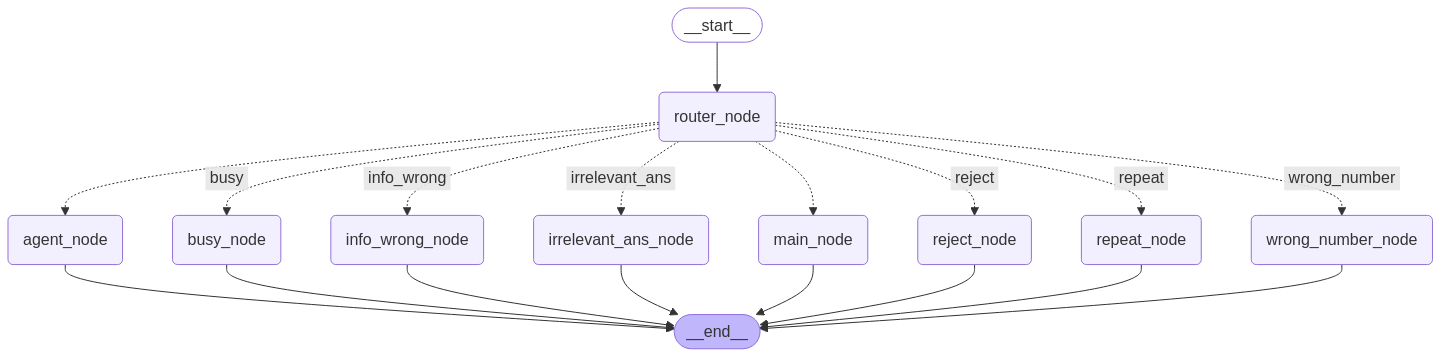

In [ ]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
bot_query= """Dear Customer, I am calling on behalf of Tata Capital. You've been shortlisted for a preapproved personal loan. Do you want to know more details?"""
import uuid
import time
session_id=str(uuid.uuid4())
questions=["मैं लोन लेना चाहते हूँ"]
for question in questions:
    st = time.time()
    request = HuamnBotQuery(
        session_id=session_id,
        bot_query=bot_query,
        customer_query=question,
        language='hi-IN'  # Hindi locale
    )
    print(f"-> *Question*: {question}\n")
    respo = handle_user_request(request)
    print(f"-> *Response*: {respo}\n")
    print("-> Response time:", round(time.time() - st, 2), "seconds\n")

ValidationError: 2 validation errors for HuamnBotQuery
session_idq
  Field required [type=missing, input_value={'session_id': '7a01e753-...', 'language': 'hi-IN'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
user_text
  Field required [type=missing, input_value={'session_id': '7a01e753-...', 'language': 'hi-IN'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

In [ ]:


# def main_node(state: State):
#     """Main node handles the RTP and PTP scenarios"""
#     if state["language"] != "Hindi":
#         result = main_pipeline.invoke({"chat_history": state["messages"], "language": state["language"], "examples_hindi": examples_hindi, "ROI": state["context"]})
#         return {
#             "messages": [AIMessage(content=result.response), HumanMessage(content=state["user_text"])],
#             "output": result.response,
#             "status": result.status,
#             "language": state["language"],
#             "today_date": str(date.today()),
#             "context": state["context"],
#         }
#     else:
#         result = main_pipeline.invoke({"chat_history": state["messages"], "language": state["language"], "examples_hindi": examples_hindi,"ROI": state["context"]})
#         return {
#             "messages": [AIMessage(content=result.response), HumanMessage(content=state["user_text"])],
#             "output": result.response,
#             "status": result.status,
#             "language": state["language"],
#             "examples_hindi": examples_hindi,
#             "today_date": str(date.today()),
#             "context": state["context"],
#         }






















ValueError: unexpected '{' in field name

# NEW FORMAT

In [ ]:
class RouteClassification(BaseModel):
    step: Literal[
        "busy", "wrong_number", "info_wrong",
        "irrelevant_ans", "reject", "repeat",
        "res_language", "agent_node", "main_node"
    ] = Field(description="Conversation step classification")
    language: Literal["English", "Hindi"] = Field(description="Response language")


router_prompt = ChatPromptTemplate.from_messages([
    ("system", """Expert classifier for loan conversations. Analyze user input and:
     - Detect language (English/Hindi)
     - Classify intent: busy, wrong_number, loan_interest, etc.
     - Route to appropriate handling node"""),
    ("placeholder", "{chat_history}"),
    ("user", "{user_input}")
])

router_chain = router_prompt | llm_router.with_structured_output(RouteClassification)

In [ ]:
router_chain.invoke({"user_input": "मैं लोन लेना चाहता हूँ"})

RouteClassification(step='main_node', language='Hindi')

In [ ]:
class NodeResponse(BaseModel):
    response: str = Field(description="Generated response text")
    status: Literal["end", "continue"] = Field(description="Conversation status")


# Main Conversation Node
main_prompt = ChatPromptTemplate.from_messages([
    ("system", """MicMaX loan expert. Handle loan inquiries in {language}.
     Follow flow: Eligibility -> Details -> Agent connection.
     Use simple {language} with financial terms."""+route_prompt),
    ("placeholder", "{chat_history}"),
    ("user", "{user_input}")
])
main_chain = main_prompt | llm_node.with_structured_output(NodeResponse)

In [ ]:
main_chain.invoke({"user_input": "मैं लोन लेना चाहते हूँ", "language": "Hindi"})

NodeResponse(response='आप लोन लेने के लिए योग्य हैं या नहीं, यह जानने के लिए कुछ जानकारी चाहिए। क्या आप मुझे बता सकते हैं कि आपकी आय कितनी है और आपकी उम्र क्या है?', status='continue')

In [ ]:
agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """Handle agent transfer requests in {language}.
     Confirm intent, collect needed info, schedule callback."""),
    ("placeholder", "{chat_history}"),
    ("user", "{user_input}")
])
agent_chain = agent_prompt | llm_node.with_structured_output(NodeResponse)

In [ ]:
agent_chain.invoke({"user_input": "मैं लोन लेना चाहते हूँ", "language": "Hindi"})

NodeResponse(response='आप लोन लेने के लिए सही जगह पर हैं। क्या आप मुझे बताना चाहेंगे कि आपको किस प्रकार का लोन चाहिए? जैसे कि व्यक्तिगत लोन, होम लोन या वाहन लोन?', status='continue')

In [ ]:
from typing import Optional
from typing import Annotated, Literal, Sequence, TypedDict
import operator
from langgraph.graph import END, StateGraph, add_messages
from langchain_core.messages import BaseMessage

class State(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]
  context:dict
  number_conversation:Annotated[int,operator.add]=1
  today_date:str
  user_text:str
  decision:str
  output:str
  status:str
  language:str
  busy_counter:Annotated[int,operator.add]=0
  refusal_counter: Annotated[int,operator.add]=0


In [ ]:
prompt_gpt_response="""Tata Capital loan expert. Handle loan inquiries in {language}.
     Follow flow: Eligibility -> Details -> Agent connection.
     Use simple {language} with financial terms."""

In [ ]:
# check this
node_message=llm_node.with_structured_output(NodeResponse)

In [ ]:
main_template=ChatPromptTemplate.from_messages(
    messages=[
        ("system",prompt_gpt_response),
        ("placeholder", "{chat_history}"),
    ]
)

In [ ]:
main_pipeline=main_template|node_message

In [ ]:
prompt_gpt_reason_diff="""hi"""

In [ ]:
main_template_diff=ChatPromptTemplate.from_messages(
    messages=[
        ("system",prompt_gpt_reason_diff),
        ("placeholder", "{chat_history}"),
    ]
)
main_pipeline_diff=main_template_diff|node_message

In [ ]:
def main_node(state:State):
  "main node handle the rtp and ptp scenarios"
  if state["number_conversation"]%3==0:
    if(state["language"]=="Hindi"):
      result=main_pipeline.invoke({"user_input":state["user_text"],"language":"English"})
      return {"messages":(AIMessage(content=result.response)),"output":result.response,"status":result.status,"date_time":str(date.time())}
    else:
      result=main_pipeline_diff.invoke({"user_input":state["user_text"],"language":"English"})
      return {"messages":(AIMessage(content=result.response)),"output":result.response,"status":result.status,"date_time":str(date.time())}
  else:
    if(state["language"]=="Hindi"):
      result=main_pipeline.invoke({"user_input":state["user_text"],"language":"English"})
      return {"messages":(AIMessage(content=result.response)),"output":result.response,"status":result.status,"date_time":str(date.time())}
    else:
      result=main_pipeline_diff.invoke({"user_input":state["user_text"],"language":"English"})
      return {"messages":(AIMessage(content=result.response)),"output":result.response,"status":result.status,"date_time":str(date.time())}

In [ ]:
agent_temp_diff=ChatPromptTemplate.from_messages(
    messages=[
        ("system",agent_gpt_reason_diff),
        ("placeholder", "{chat_history}"),
    ]
)
agent_pipeline_diff=agent_temp_diff|node_message

In [ ]:
def llm_call_router(state:State):
  "Route the input to the appropriate node"
  print("#"*25)
  decision=router_chain.invoke(
      [
          SystemMessage(content="""Analysis the human response and set the step to busy,wrong_number,info_wrong,main_node,agent_node,"""),
          HumanMessage(content=state["user_text"])
      ]
  )
  return {"decision":decision.step,"language":decision.language}

In [ ]:
def route_decision(state:State):
  "Route the input to the appropriate node"
  if(state["decision"]=="busy"):
    return "busy"
  elif(state["decision"]=="wrong_number"):
    return "wrong_number"
  elif(state["decision"]=="info_wrong"):
    return "info_wrong"
  elif(state["decision"]=="irrelevant_ans"):
    return "irrelevant_ans"
  elif(state["decision"]=="reject"):
    return "reject"
  elif(state["decision"]=="repeat"):
    return "repeat"
  else:
    return "main_node"


In [ ]:
def busy_node(state:State):
  return {"messages":(AIMessage(content="")),"output":"","status":"end","date_time":str(date.time())}

def wrong_number_node(state:State):
  return {"messages":(AIMessage(content="")),"output":"","status":"end","date_time":str(date.time())}

def info_wrong_node(state:State):
  return {"messages":(AIMessage(content="")),"output":"","status":"end","date_time":str(date.time())}

def irrelevant_ans_node(state:State):
  return {"messages":(AIMessage(content="")),"output":"","status":"end","date_time":str(date.time())}

def reject_node(state:State):
  return {"messages":(AIMessage(content="")),"output":"","status":"end","date_time":str(date.time())}

def repeat_node(state:State):
  return {"messages":(AIMessage(content="")),"output":"","status":"end","date_time":str(date.time())}

def agent_node(state:State):
  return {"messages":(AIMessage(content="")),"output":"","status":"end","date_time":str(date.time())}


In [ ]:
graph=StateGraph(State)
graph.add_node("busy_node",busy_node)
graph.add_node("wrong_number_node",wrong_number_node)
graph.add_node("info_wrong_node",info_wrong_node)
graph.add_node("irrelevant_ans_node",irrelevant_ans_node)
graph.add_node("reject_node",reject_node)
graph.add_node("repeat_node",repeat_node)
graph.add_node("main_node",main_node)
graph.add_node("agent_node",agent_node)
graph.add_node("router_node",llm_call_router)

graph.add_conditional_edges("router_node",route_decision,{
    "busy":"busy_node",
    "wrong_number":"wrong_number_node",
    "info_wrong":"info_wrong_node",
    "irrelevant_ans":"irrelevant_ans_node",
    "reject":"reject_node",
    "repeat":"repeat_node",
    "main_node":"main_node",
    "agent_node":"agent_node"
})
graph.add_edge(START,"router_node")
graph.add_edge("busy_node",END)
graph.add_edge("wrong_number_node",END)
graph.add_edge("info_wrong_node",END)
graph.add_edge("irrelevant_ans_node",END)
graph.add_edge("reject_node",END)
graph.add_edge("repeat_node",END)
graph.add_edge("main_node",END)
graph.add_edge("agent_node",END)

from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

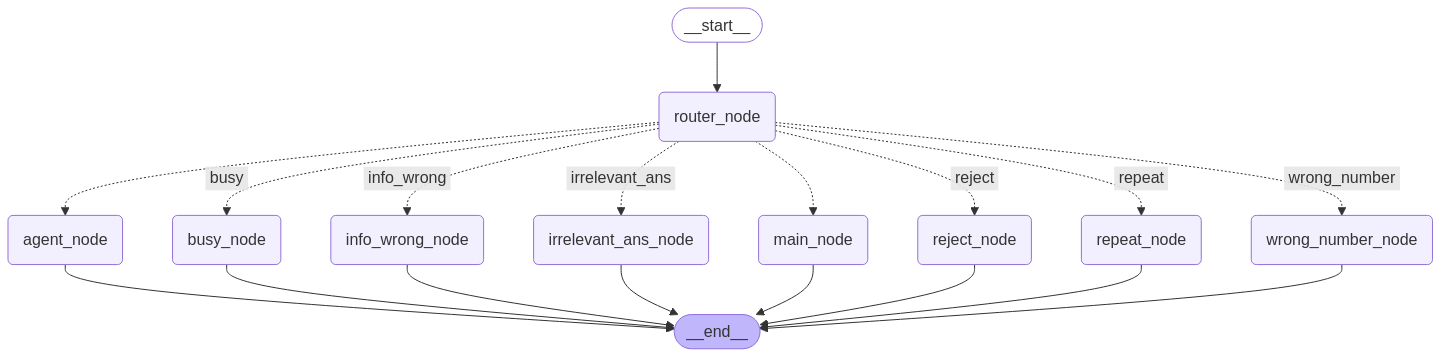

In [ ]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass